In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
def lr_schedule(epoch):
    initial_lr = 0.001 
    drop = 0.5  
    epochs_drop = 10 
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return max(lr,0.0001)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=150,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [8]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [9]:
base_model = VGG16(weights='imagenet', include_top=False)


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
x= Dense(1024,activation = 'relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['categorical_accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
history = model.fit(train_dataset, validation_data=val_dataset,  epochs=75,callbacks = [LearningRateScheduler(lr_schedule)])

Epoch 1/75
463/463 [==============================] - 90s 185ms/step - loss: 0.6704 - categorical_accuracy: 0.7400 - val_loss: 0.4980 - val_categorical_accuracy: 0.8122
Epoch 2/75
463/463 [==============================] - 80s 172ms/step - loss: 0.4614 - categorical_accuracy: 0.8253 - val_loss: 0.4307 - val_categorical_accuracy: 0.8405
Epoch 3/75
463/463 [==============================] - 84s 181ms/step - loss: 0.4066 - categorical_accuracy: 0.8490 - val_loss: 0.3430 - val_categorical_accuracy: 0.8759
Epoch 4/75
463/463 [==============================] - 83s 180ms/step - loss: 0.3675 - categorical_accuracy: 0.8612 - val_loss: 0.3591 - val_categorical_accuracy: 0.8764
Epoch 5/75
463/463 [==============================] - 86s 186ms/step - loss: 0.3564 - categorical_accuracy: 0.8660 - val_loss: 0.3055 - val_categorical_accuracy: 0.8867
Epoch 6/75
463/463 [==============================] - 85s 183ms/step - loss: 0.3278 - categorical_accuracy: 0.8787 - val_loss: 0.3143 - val_categorical_acc

463/463 [==============================] - 92s 200ms/step - loss: 0.1168 - categorical_accuracy: 0.9584 - val_loss: 0.2875 - val_categorical_accuracy: 0.9099
Epoch 50/75
463/463 [==============================] - 94s 203ms/step - loss: 0.1147 - categorical_accuracy: 0.9573 - val_loss: 0.2883 - val_categorical_accuracy: 0.9084
Epoch 51/75
463/463 [==============================] - 92s 198ms/step - loss: 0.1132 - categorical_accuracy: 0.9583 - val_loss: 0.2914 - val_categorical_accuracy: 0.9066
Epoch 52/75
463/463 [==============================] - 91s 196ms/step - loss: 0.1122 - categorical_accuracy: 0.9589 - val_loss: 0.3083 - val_categorical_accuracy: 0.8990
Epoch 53/75
463/463 [==============================] - 92s 198ms/step - loss: 0.1092 - categorical_accuracy: 0.9598 - val_loss: 0.2968 - val_categorical_accuracy: 0.9075
Epoch 54/75
463/463 [==============================] - 95s 204ms/step - loss: 0.1087 - categorical_accuracy: 0.9602 - val_loss: 0.3085 - val_categorical_accuracy:

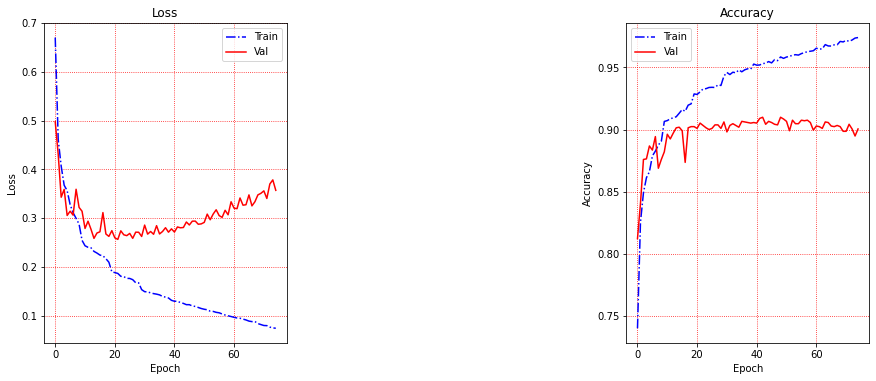

In [12]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['categorical_accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_categorical_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

In [13]:
test_result = model.evaluate(test_dataset, batch_size = 128)

29/29 [==============================] - 24s 818ms/step - loss: 0.4112 - categorical_accuracy: 0.8996


In [14]:
print('Test Loss: {}'.format(test_result[0]))
print('Test Accuracy: {}'.format(test_result[1]))

Test Loss: 0.41120198369026184
Test Accuracy: 0.8996458053588867


In [15]:
class_names = list(train_dataset.class_indices)

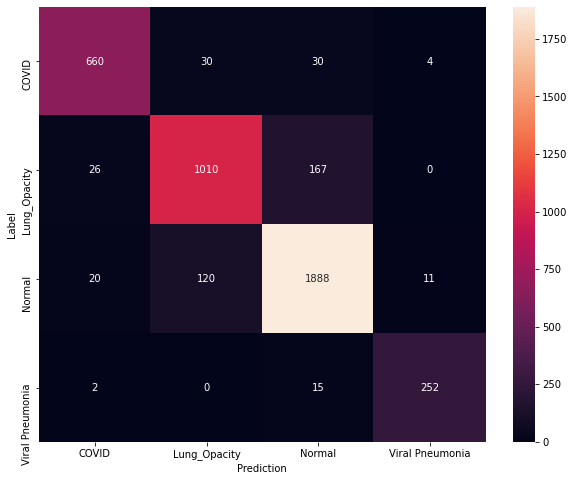

In [16]:
label_names = class_names
y_pred = model.predict(test_dataset, batch_size=128)
y_test = test_dataset.labels
cm = tf.math.confusion_matrix(y_test, 
                              y_pred.argmax(axis=1),
                              num_classes = 4)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, 
              annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('CM.png', dpi = 300)
plt.show()